In [1]:
from pathlib import Path
DATA_ROOT = Path(r"c:\\Users\\kanur\\Downloads\\archive")
SPLIT_OUT = DATA_ROOT / "split_out"
CSV_INDEX = SPLIT_OUT / "dataset_index.csv"
IMAGE_SIZE = 160  # reduced for faster HOG
TUNE_MAX_SAMPLES = 3000
BN_MAX_TRAIN = 2000
BN_MAX_TEST = 1000

In [2]:
import os, sys
import pandas as pd
from pathlib import Path
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
assert CSV_INDEX.exists(), "dataset_index.csv not found. Run make_split_csv.py first."

In [3]:
# Ensure required packages are installed
import sys, subprocess
def _ensure(pkg):
    try:
        __import__(pkg)
        print(f"{pkg} already installed")
    except Exception:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
        except Exception as e:
            print(f'Warning: could not install {pkg}: {e}')
for pkg in ['scikit-image', 'xgboost', 'pgmpy']:
    _ensure(pkg)

xgboost already installed


In [4]:
df = pd.read_csv(CSV_INDEX)
display(df.head())
display(df.groupby("split").size())
display(df.groupby(["split","label"]).size().unstack(fill_value=0))

,split,label,path
0,train,normal,c:\Users\kanur\Downloads\archive\train\normal\...
1,train,normal,c:\Users\kanur\Downloads\archive\train\normal\...
2,train,normal,c:\Users\kanur\Downloads\archive\train\normal\...
3,train,normal,c:\Users\kanur\Downloads\archive\train\normal\...
4,train,normal,c:\Users\kanur\Downloads\archive\train\normal\...


split
test     2251
train    7500
dtype: int64

label,normal,pneumonia,tuberculosis
split,,,
test,763,545,943
train,2500,2500,2500


In [5]:
def load_image(path):
    im = Image.open(path)
    im = ImageOps.exif_transpose(im)
    if im.mode != "RGB":
        im = im.convert("RGB")
    return im

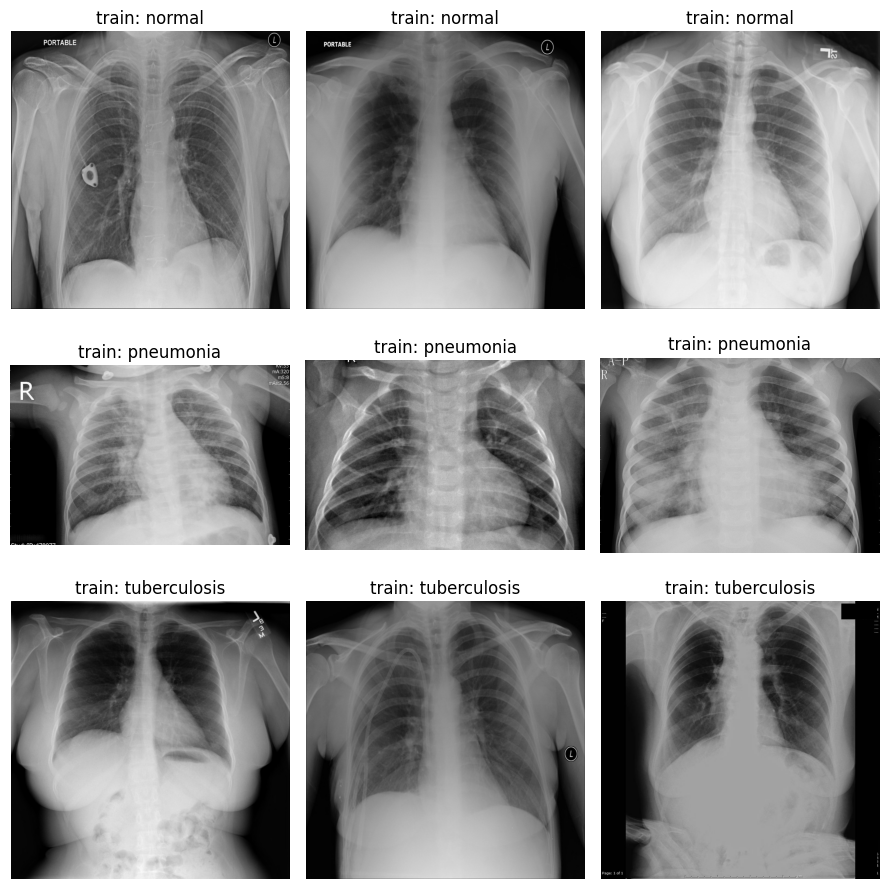

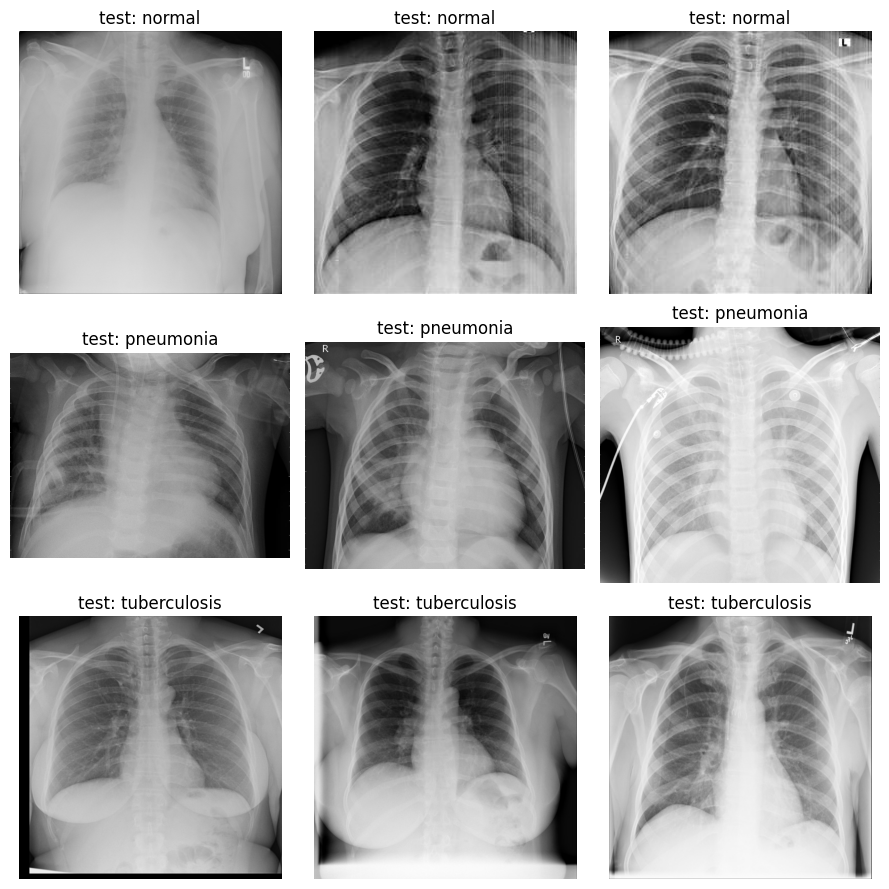

In [6]:
def preview_grid(df, split="train", n_per_class=3):
    subset = df[df["split"] == split]
    labels = sorted(subset["label"].unique())
    paths = []
    for label in labels:
        ex = subset[subset["label"] == label]["path"].head(n_per_class).tolist()
        paths.append((label, ex))
    cols = max(len(paths[0][1]) if paths else 0, 1)
    rows = len(paths)
    plt.figure(figsize=(cols*3, rows*3))
    i = 1
    for r, (label, exs) in enumerate(paths):
        for c, p in enumerate(exs):
            try:
                im = load_image(p)
                plt.subplot(rows, cols, i)
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"{split}: {label}")
            except Exception as e:
                plt.subplot(rows, cols, i)
                plt.axis('off')
            i += 1
    plt.tight_layout()
preview_grid(df, split="train", n_per_class=3)
preview_grid(df, split="test", n_per_class=3)

In [7]:
label_to_idx = {l: i for i, l in enumerate(sorted(df['label'].unique()))}
idx_to_label = {v: k for k, v in label_to_idx.items()}
label_to_idx

{'normal': 0, 'pneumonia': 1, 'tuberculosis': 2}

In [8]:
import json, pickle, os
from skimage.feature import hog
from skimage.transform import resize

CACHE_DIR = DATA_ROOT / "feature_cache"
CACHE_DIR.mkdir(exist_ok=True)
CACHE_FILE = CACHE_DIR / f"hog_{IMAGE_SIZE}.pkl"

def extract_hog_feature(img_rgb, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9):
    arr = np.asarray(img_rgb, dtype=np.float32) / 255.0
    gray = np.dot(arr[..., :3], [0.299, 0.587, 0.114])
    gray_resized = resize(gray, (IMAGE_SIZE, IMAGE_SIZE), order=1, anti_aliasing=True, preserve_range=True)
    feat = hog(gray_resized, orientations=orientations, pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    return feat.astype(np.float32)

def build_features(df):
    if CACHE_FILE.exists():
        with open(CACHE_FILE, 'rb') as f:
            cache = pickle.load(f)
        if cache.get('image_size') == IMAGE_SIZE and cache.get('paths_count') == len(df):
            return cache['X'], cache['y'], cache['paths']
    X, y, paths = [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc='HOG features'):
        p = row['path']
        try:
            im = load_image(p)
            feat = extract_hog_feature(im)
            X.append(feat)
            y.append(label_to_idx[row['label']])
            paths.append(p)
        except Exception:
            continue
    if not X:
        raise RuntimeError("No features extracted. Ensure scikit-image is installed: pip install scikit-image")
    X = np.vstack(X).astype(np.float32)
    y = np.asarray(y, dtype=np.int64)
    with open(CACHE_FILE, 'wb') as f:
        pickle.dump({'X': X, 'y': y, 'paths': paths, 'image_size': IMAGE_SIZE, 'paths_count': len(df)}, f)
    return X, y, paths

df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_test = df[df['split'] == 'test'].reset_index(drop=True)
X_train, y_train, _ = build_features(df_train)
X_test, y_test, _ = build_features(df_test)
X_train.shape, X_test.shape

HOG features: 100%|██████████| 7500/7500 [08:42<00:00, 14.36it/s]

HOG features: 100%|██████████| 2251/2251 [02:50<00:00, 13.23it/s]



((7500, 12996), (2251, 12996))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import train_test_split
X_tr_full, X_val_full, y_tr_full, y_val_full = train_test_split(X_train_std, y_train, test_size=0.2, random_state=42, stratify=y_train)
if len(y_tr_full) > TUNE_MAX_SAMPLES:
    rs = np.random.RandomState(42)
    idx = rs.choice(len(y_tr_full), size=TUNE_MAX_SAMPLES, replace=False)
    X_tr = X_tr_full[idx]
    y_tr = y_tr_full[idx]
else:
    X_tr, y_tr = X_tr_full, y_tr_full
X_val, y_val = X_val_full, y_val_full
X_tr.shape, X_val.shape

((3000, 12996), (1500, 12996))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

fast_models = {
    'LogReg': LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs'),
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='distance'),
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(max_depth=20, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=None, n_jobs=-1, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=150, learning_rate=0.8, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(256,), max_iter=150, early_stopping=True, n_iter_no_change=10, random_state=42),
}

best_models = {}
results = []
for name, clf in fast_models.items():
    clf.fit(X_train_std, y_train)
    y_pred = clf.predict(X_test_std)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    results.append({'model': name, 'accuracy': acc, 'f1_macro': f1m})
    best_models[name] = clf

import pandas as pd
fast_results_df = pd.DataFrame(results).sort_values(by=['f1_macro','accuracy'], ascending=False)
fast_results_df

,model,accuracy,f1_macro
2,SVM-RBF,0.798756,0.809343
5,RandomForest,0.776100,0.785621
7,MLP,0.769880,0.779245
1,KNN,0.742781,0.757785
0,LogReg,0.737006,0.747872
3,NaiveBayes,0.705020,0.722281
6,AdaBoost,0.685029,0.694235
4,DecisionTree,0.642825,0.654626


In [12]:
try:
    import xgboost as xgb
    xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.9, colsample_bytree=0.9, n_jobs=-1, random_state=42, eval_metric='mlogloss')
    xgb_model.fit(X_train_std, y_train)
    from sklearn.metrics import accuracy_score, f1_score
    y_pred = xgb_model.predict(X_test_std)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    fast_results_df = pd.concat([fast_results_df, pd.DataFrame([{'model':'XGBoost','accuracy':acc,'f1_macro':f1m}])], ignore_index=True)
    best_models['XGBoost'] = xgb_model
except Exception as e:
    print('XGBoost not available or failed:', e)

In [ ]:
try:
    import pandas as _pd
    import numpy as _np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import KBinsDiscretizer
    from pgmpy.estimators import HillClimbSearch, BicScore
    from pgmpy.models import BayesianNetwork
    from pgmpy.inference import VariableElimination
    _has_pgmpy = True
except Exception:
    _has_pgmpy = False

def fit_bayesian_network(X_train, y_train, X_test, max_train=BN_MAX_TRAIN, max_test=BN_MAX_TEST):
    rs = _np.random.RandomState(42)
    if len(y_train) > max_train:
        idx = rs.choice(len(y_train), size=max_train, replace=False)
        X_train, y_train = X_train[idx], y_train[idx]
    if X_test.shape[0] > max_test:
        idx_te = _np.arange(X_test.shape[0])[:max_test]
        X_test = X_test[idx_te]
    pca = PCA(n_components=min(20, X_train.shape[1]))
    Xtr_pca = pca.fit_transform(X_train)
    Xte_pca = pca.transform(X_test)
    kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    Xtr_disc = kb.fit_transform(Xtr_pca).astype(int)
    Xte_disc = kb.transform(Xte_pca).astype(int)
    df_tr = _pd.DataFrame(Xtr_disc, columns=[f"f{i}" for i in range(Xtr_disc.shape[1])])
    df_tr['Y'] = y_train.astype(int)
    hc = HillClimbSearch(df_tr, scoring_method=BicScore(df_tr))
    model = hc.estimate()
    bn = BayesianNetwork(model.edges())
    bn.fit(df_tr, estimator=None)
    infer = VariableElimination(bn)
    df_te = _pd.DataFrame(Xte_disc, columns=[f"f{i}" for i in range(Xte_disc.shape[1])])
    y_pred = []
    for _, row in df_te.iterrows():
        ev = row.to_dict()
        q = infer.query(variables=['Y'], evidence=ev, show_progress=False)
        y_pred.append(int(_np.argmax(q.values)))
    return _np.array(y_pred)

if _has_pgmpy:
    try:
        y_pred_bn = fit_bayesian_network(X_train_std, y_train, X_test_std)
        acc_bn = accuracy_score(y_test, y_pred_bn)
        f1_bn = f1_score(y_test, y_pred_bn, average='macro')
        fast_results_df = _pd.concat([fast_results_df, _pd.DataFrame([{'model':'BayesianNetwork','accuracy':acc_bn,'f1_macro':f1_bn}])], ignore_index=True)
        best_models['BayesianNetwork'] = ('BN-PCA-Disc', {'pca': True, 'bins': 5})
    except Exception as e:
        pass 
else:
    pass 

C:\Users\kanur\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


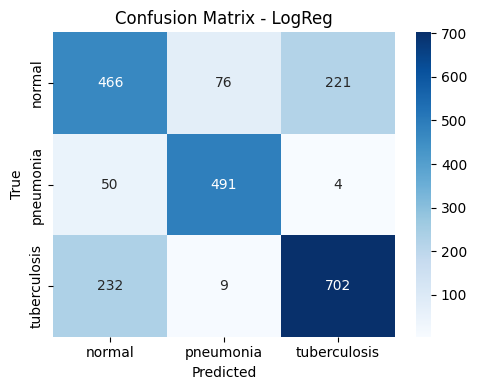

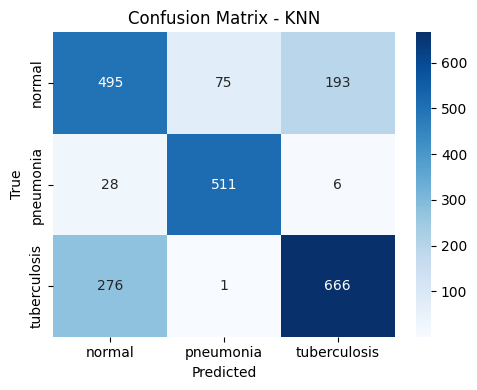

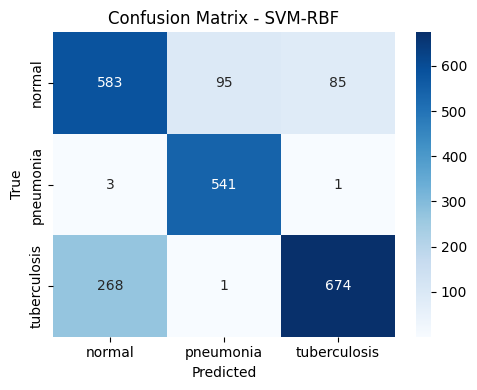

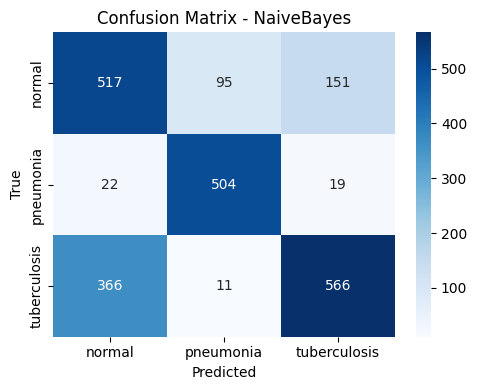

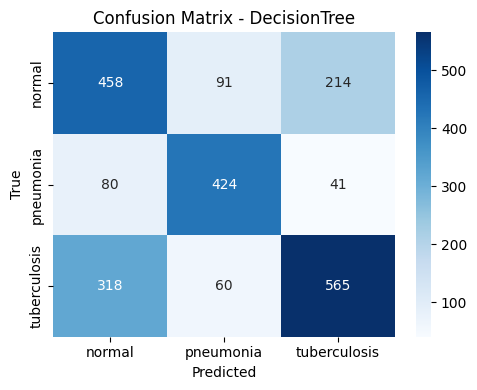

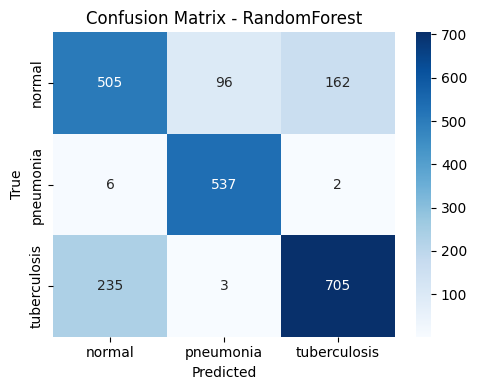

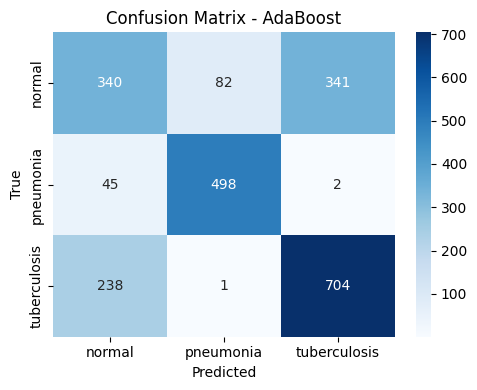

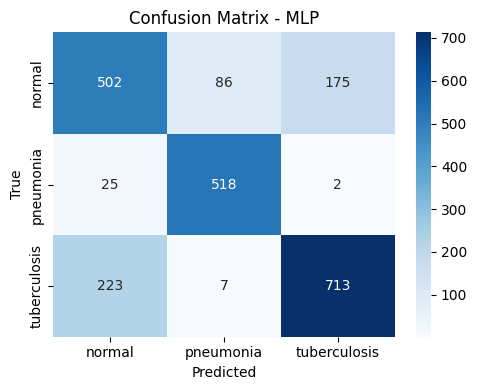

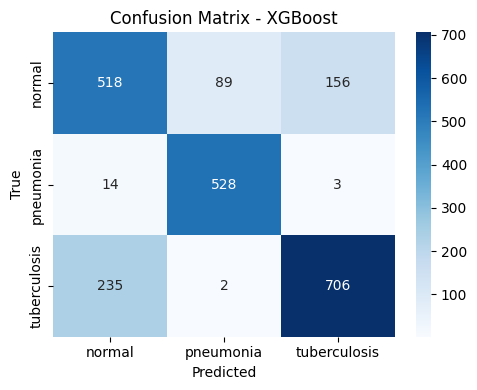

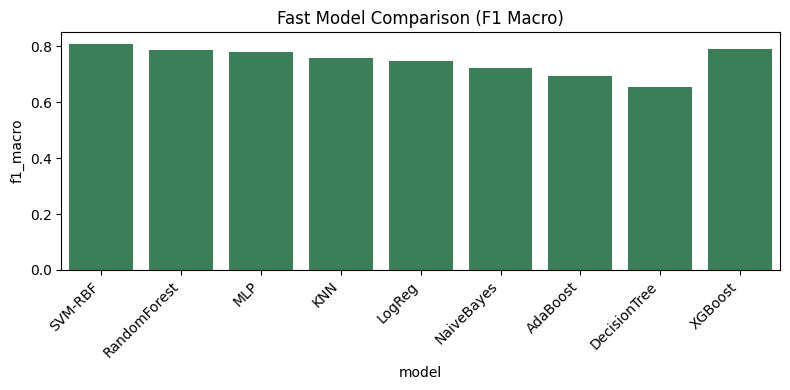

In [14]:
labels_sorted = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
for name, model in best_models.items():
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(X_test_std)
    cm = confusion_matrix(y_test, y_pred, labels=sorted(idx_to_label.keys()))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

import seaborn as sns
plt.figure(figsize=(8,4))
sns.barplot(data=fast_results_df, x='model', y='f1_macro', color='seagreen')
plt.title('Fast Model Comparison (F1 Macro)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
import os, json
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score, balanced_accuracy_score,
                             accuracy_score, f1_score)
RESULTS_DIR = DATA_ROOT / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

def one_vs_rest_scores(model, X, y_true, n_classes):
    if hasattr(model, 'predict_proba') and callable(model.predict_proba):
        proba = model.predict_proba(X)
    elif hasattr(model, 'decision_function') and callable(model.decision_function):
        scores = model.decision_function(X)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        e = np.exp(scores - scores.max(axis=1, keepdims=True))
        proba = e / e.sum(axis=1, keepdims=True)
    else:
        return np.nan, np.nan
    y_bin = np.eye(n_classes)[y_true]
    try:
        roc_macro = roc_auc_score(y_bin, proba, average='macro', multi_class='ovr')
    except Exception:
        roc_macro = np.nan
    try:
        pr_macro = average_precision_score(y_bin, proba, average='macro')
    except Exception:
        pr_macro = np.nan
    return roc_macro, pr_macro

def evaluate_model(name, model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    bal_acc = balanced_accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_weighted = f1_score(y, y_pred, average='weighted')
    report = classification_report(y, y_pred, target_names=[idx_to_label[i] for i in sorted(idx_to_label.keys())], output_dict=True, zero_division=0)
    roc_macro, pr_macro = one_vs_rest_scores(model, X, y, n_classes=len(idx_to_label))
    return {
        'model': name,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc_macro': roc_macro,
        'pr_auc_macro': pr_macro,
        'report': report,
        'y_pred': y_pred,
    }

all_metrics = []
for name, model in best_models.items():
    m = evaluate_model(name, model, X_test_std, y_test)
    all_metrics.append(m)

import pandas as pd
metrics_table = pd.DataFrame([{k:v for k,v in m.items() if k not in ['report','y_pred']} for m in all_metrics])
metrics_table = metrics_table.sort_values(by=['f1_macro','accuracy'], ascending=False)
metrics_table.to_csv(RESULTS_DIR / 'metrics_test.csv', index=False)
metrics_table

,model,accuracy,balanced_accuracy,f1_macro,f1_weighted,roc_auc_macro,pr_auc_macro
2,SVM-RBF,0.798756,0.823830,0.809343,0.797649,0.923364,0.854697
8,XGBoost,0.778321,0.798794,0.788438,0.776338,0.923736,0.853878
5,RandomForest,0.776100,0.798265,0.785621,0.773036,0.911755,0.834660
7,MLP,0.769880,0.788162,0.779245,0.767816,0.916510,0.836249
1,KNN,0.742781,0.764209,0.757785,0.742054,0.898274,0.812790
0,LogReg,0.737006,0.752032,0.747872,0.735697,0.899773,0.821887
3,NaiveBayes,0.705020,0.734190,0.722281,0.703867,0.839744,0.685800
6,AdaBoost,0.685029,0.701975,0.694235,0.676868,0.844530,0.713466
4,DecisionTree,0.642825,0.659132,0.654626,0.643604,0.740208,0.559286


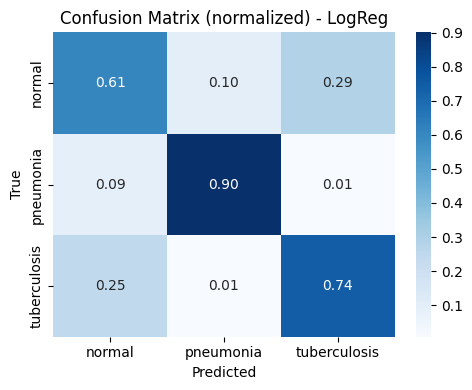

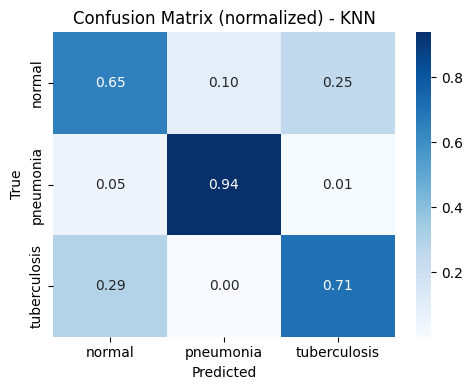

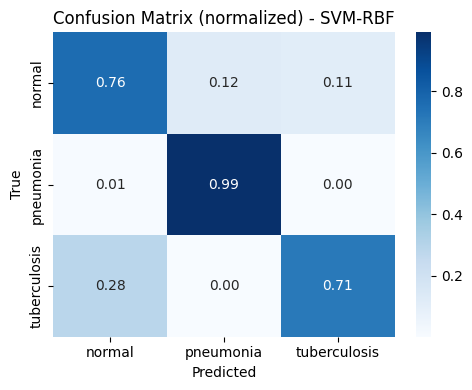

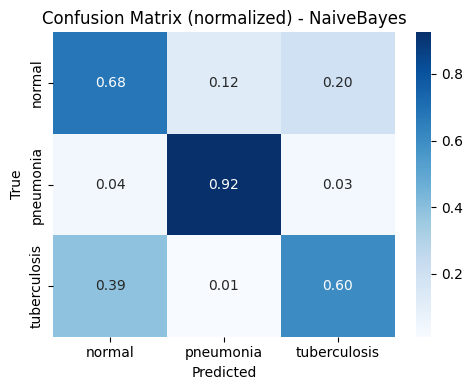

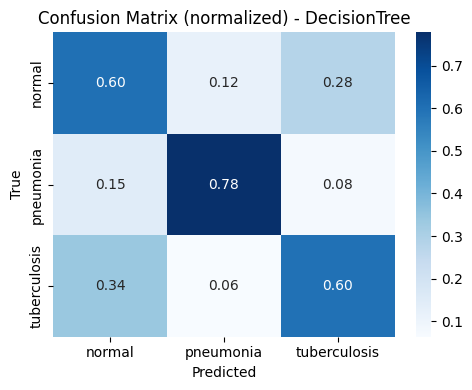

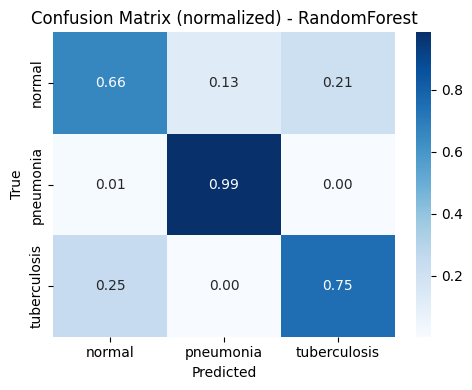

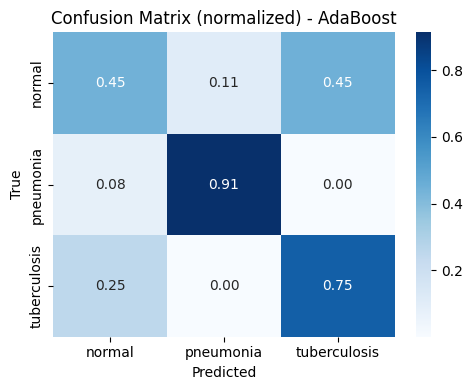

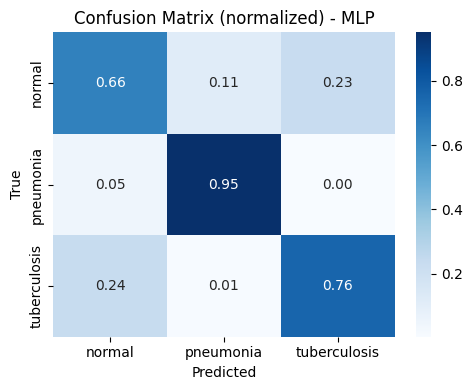

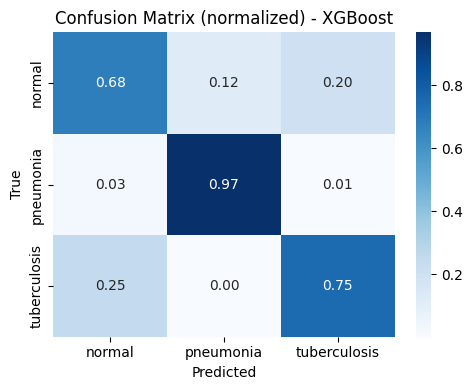

In [16]:
labels_sorted = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
for m in all_metrics:
    name = m['model']
    with open(RESULTS_DIR / f'report_{name}.json', 'w', encoding='utf-8') as f:
        json.dump(m['report'], f, indent=2)
    y_pred = m['y_pred']
    cm = confusion_matrix(y_test, y_pred, labels=sorted(idx_to_label.keys()), normalize='true')
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.title(f'Confusion Matrix (normalized) - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

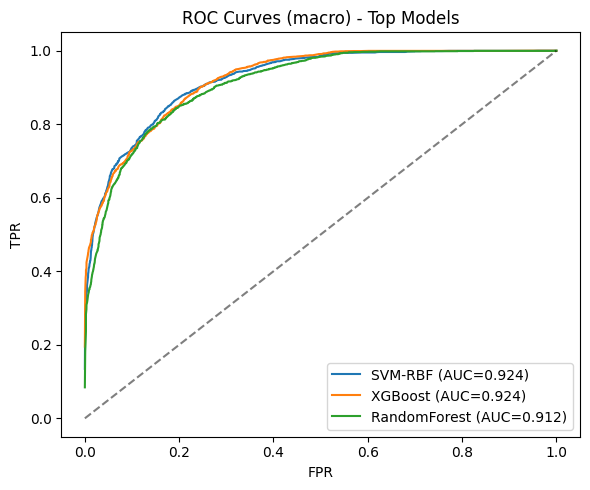

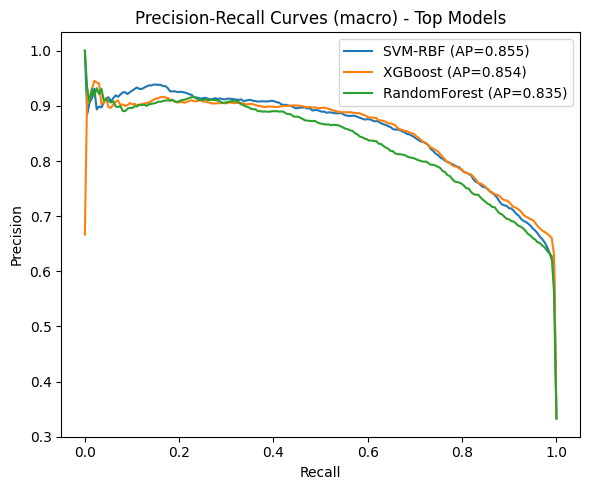

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
TOP_N = 3

def _get_proba_or_scores(model, X):
    if hasattr(model, 'predict_proba') and callable(model.predict_proba):
        return model.predict_proba(X)
    if hasattr(model, 'decision_function') and callable(model.decision_function):
        s = model.decision_function(X)
        if s.ndim == 1:
            s = np.vstack([-s, s]).T
        # convert scores to probs via softmax-like normalization
        e = np.exp(s - s.max(axis=1, keepdims=True))
        return e / e.sum(axis=1, keepdims=True)
    return None

top_models = fast_results_df.sort_values(by=['f1_macro','accuracy'], ascending=False)['model'].head(TOP_N).tolist()
classes = sorted(idx_to_label.keys())
y_test_bin = label_binarize(y_test, classes=classes)

# ROC curves (macro)
plt.figure(figsize=(6,5))
for name in top_models:
    model = best_models.get(name)
    if model is None:
        continue
    proba = _get_proba_or_scores(model, X_test_std)
    if proba is None or proba.shape[1] != len(classes):
        continue
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i, c in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    macro_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC={macro_auc:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title('ROC Curves (macro) - Top Models')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall curves (macro)
plt.figure(figsize=(6,5))
for name in top_models:
    model = best_models.get(name)
    if model is None:
        continue
    proba = _get_proba_or_scores(model, X_test_std)
    if proba is None or proba.shape[1] != len(classes):
        continue
    precisions = []; recalls = []
    for i, c in enumerate(classes):
        p, r, _ = precision_recall_curve(y_test_bin[:, i], proba[:, i])
        precisions.append(p); recalls.append(r)
    recall_grid = np.linspace(0, 1, 200)
    interp_prec = []
    for p, r in zip(precisions, recalls):
        interp_prec.append(np.interp(recall_grid, r[::-1], p[::-1]))
    mean_prec = np.mean(np.vstack(interp_prec), axis=0)
    ap_macro = average_precision_score(y_test_bin, proba, average='macro')
    plt.plot(recall_grid, mean_prec, label=f"{name} (AP={ap_macro:.3f})")
plt.title('Precision-Recall Curves (macro) - Top Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()